# Coordinate free cell elongation alignment at distance $k$ 

### Required software

- Python >= 3.6
- Numpy
- Pandas
- [igraph for Python](https://anaconda.org/conda-forge/python-igraph) 
- netCDF4

Make sure you have the latest version of igraph: v0.8.2! The installer might take an older version by default. To force the latets version:

`conda install -c conda-forge python-igraph=0.82`

You also need netCDF4 that can be downloaded and installed using 

`pip install netCDF4`

### Method outline

Given the cellular network of the tissue and the elongation tensor, $\mathbf{q}^\alpha$, on every cell $\alpha$, defined as

$$ \mathbf{q}^\alpha = \frac{1}{A^\alpha} \sum_m a^m \mathbf{q}^m $$

where $A^\alpha$ is the area of the cell, $a^m$ the area, $\mathbf{q}^m$ the triangle elongation tensor lying in the plane of a subcellular triangle contained in the cell polygon $m$. Then

- Define the graph $g$ of the cell network, where every cell is a node and the neighbors of each cell define the edges of the graph.
- Then, for every cell $\alpha$ in the network, find the set of cells that are on a ring $k$ steps away from $\alpha$, $R_k(\alpha)$. This set is defined as those cells that are in the neighborhood of order $k$ of cell $\alpha$, $N_k(\alpha)$, but are not in the neighborhood with order $k-1$

$$ R_k(\alpha) = N_k(\alpha) - N_{k-1}(\alpha) $$

- We find the mean alignment of the cell elongation tensors of cell $\alpha$ with the cells $k$ hops away as:


$$ \Omega^\alpha_k = \frac{1}{M^\alpha_k}\sum_{\beta\in R_k(\alpha)} \langle \hat{\mathbf{q}}^\alpha, \hat{\mathbf{q}}^\beta \rangle \,.$$

Here, $M^\alpha_k$ is the number of cells that are $k$ hops away from cell $\alpha$, $\langle \mathbf{A}, \mathbf{B} \rangle$ is the matrix scalar product defined below and $\hat{\mathbf{q}}$ is the cell elongation tensor $\mathbf{q}$ divided by its norm $|\mathbf{q}|=\sqrt{\langle \mathbf{q}, \mathbf{q} \rangle}$.

- We find the mean alignment against the distance $k$, averaged over all cells as

$$ \Omega_k = \sum_\alpha \Omega^\alpha_k \,.$$

### Scalar product and norm of a matrix:

We define the scalar product between two matrices $\mathbf{A}$ and $\mathbf{B}$ as:
$$\langle \mathbf{A}, \mathbf{B} \rangle =\frac{1}{2}\mathrm{Tr}[\mathbf{A}^T\cdot\mathbf{B}]=\frac{1}{2}\sum_{i,j} A_{ij} B_{ij},$$
and the norm of a matrix $\mathbf{M}$ reads:
$$|\mathbf{M}|=\sqrt{\mathrm{Tr}[\mathbf{M}^T\cdot\mathbf{M}]/2}.$$

Note that the $1/2$ differs from the usual definitions of the Frobenius scalar product and norm. We add it such that a symmetric traceless matrix $\mathbf{q}$ in dimension two has a norm:
$$|q|^2 = q_{xx}^2+q_{xy}^2 \, .$$



In [1]:
%load_ext autoreload
%autoreload 2

import os
import pwd
import sys
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as lin

import igraph as ig

# Load Curved Tissue Miner packages
import curvedtm
from curvedtm import MMCoarse
from curvedtm import MMTool

In [2]:
### Set path to directory containing the Tissue Miner movies and the name of specific name.
username = 'duclut'

datapath_tissue_miner = '/data/biophys/' + username + '/data_wing/' 

movie_name = '20161110_116hrAEL_400nM20E'

datapath_movie_name   = os.path.join(datapath_tissue_miner, movie_name)
datapath_movie_frames = os.path.join(datapath_movie_name, 'frames/')

In [3]:
curved_surface = curvedtm.CurvedTM(datapath_movie_name, 
                                   network_type = 'subcellular_triangles',  
                                   frames_to_process = [-1], 
                                   refresh_DB_tables = False, 
                                   refresh_fundaments = True, 
                                   refresh_geometry = True,
                                   refresh_triangle_state = True,
                                   refresh_cell_state = True)

Output directory: /data/biophys/duclut/data_wing/20161110_116hrAEL_400nM20E/frames
Tissue Miner DB Loader for movie 20161110_116hrAEL_400nM20E inititalized.
Triangulation of movie 20161110_116hrAEL_400nM20E for network type subcellular_triangles inititalized.
Execute 'run()','run_parallel()' or 'run_frame(frameIdx)' to start the Curved Tissue Miner.


In [4]:
frameIdx = 72

### Create graph of cellular network

Create a graph $g$ in which every cell is a node and every neighbor relation is an edge in the graph.

In [5]:
# Load data
cells_dbonds_id_flat, cells_nn = curved_surface.load_data_tables(frameIdx, ['/cells/sorted_cell_dbonds_per_frame_dbonds_id', '/cells/sorted_cell_dbonds_per_frame_nn'], 'list')
cells = curvedtm.load_table(datapath_movie_frames, table_name = 'cells', frameIdx = frameIdx, network_type = 'cells')
cell_dbonds = curvedtm.load_table(datapath_movie_frames, 'dbonds', frameIdx)

# Create cell_id -> cell_idx dict.
cells_id = np.array(list(cells.index))
cell_id_to_cell_idx_dict = dict(zip(cells_id, range(len(cells_id))))

# Convert cell -> dbonds to cell -> neighbor cell ids.
cells_conj_dbonds_id_flat = cell_dbonds['conj_dbond_id'].iloc[cells_dbonds_id_flat].values
cells_neighbors_id_flat   = cell_dbonds['cell_id'].iloc[cells_conj_dbonds_id_flat].values

# Convert cell ids to cell idx, ignore boundary cells.
edges_start_cidx = [cell_idx for cell_idx, nn in enumerate(cells_nn) for i in range(nn)]

edges_end_cidx_filt   = [cell_id_to_cell_idx_dict[cid] for cid in cells_neighbors_id_flat if cid != 10000]
edges_start_cidx_filt = [start_cidx for (start_cidx, neighbor_idx) in zip(edges_start_cidx, cells_neighbors_id_flat) if neighbor_idx != 10000]

assert (np.unique(edges_start_cidx_filt) == np.unique(edges_end_cidx_filt) ).any()
N_cells   = len(np.unique(edges_start_cidx_filt))
cells_idx = list(range(N_cells))

# Create graph egdes (cell_idx -> neighbor_idx)
graph_edges = list(zip(edges_start_cidx_filt, edges_end_cidx_filt))

# Create igraph object
g = ig.Graph(n=N_cells, edges=list(graph_edges), directed=False)
g.vs['id'] = cells_id

### Find cells at distance $k$ in graph.

In [6]:
### Max order used for finding the rings.
max_order = 25

### Construct rings of cell ids.
# Cell neighborhood of order k-1
cells_neighborhood_k_1 = list(range(N_cells))
# Cell neighborhood of order k.
cells_neighborhood_k = []
# Store cell rings
cells_ring_k_list = []

for neighborhood_order in range(1, max_order):
    print('\rObtaining rings of order:', str(neighborhood_order) + '/' + str(max_order), end='')
    
    cells_neighborhood_k = g.neighborhood(cells_idx, order=neighborhood_order)
    
    cells_ring_k = [np.setdiff1d(cell_nb_k, cell_nb_k_1) for cell_nb_k, cell_nb_k_1 in zip(cells_neighborhood_k, cells_neighborhood_k_1)] 
    cells_ring_k_list.append(cells_ring_k)
            
    cells_neighborhood_k_1 = cells_neighborhood_k
print('\nDone')

Obtaining rings of order: 24/25
Done


### Calculate the cell-cell elongation alignment at every distance $k$.

We calculate the alignment between the elongation of any 2 cells $\alpha$ and $\beta$
$$ \Omega^{\alpha\beta} =  \langle \hat{\mathbf{q}}^\alpha, \hat{\mathbf{q}}^\beta \rangle\,.$$

To remove contributions to the angle $\Omega^{\alpha\beta}$ stemming from the curvature of the surface, we (optionally) rotate each tensor $\mathbf{q}^\beta$ to align its normal $\mathbf{n}^\beta$ with the normal $\mathbf{n}^\alpha$ of the tensor $\mathbf{q}^\alpha$. Note that the normal vector $\mathbf{n}^\alpha$ is the unit vector that is normal to the plane of the nematic tensor (this is the eigenvector of $\mathbf{q}^{\alpha}$ with the eigenvalue closest to zero) and pointing into the space set by the orientation of the surface.

The rotation is made around the axis orthogonal to both normals, such that the rotated tensor $\mathbf{q'}^\beta$ reads:
$$ \mathbf{q'}^\beta = \mathbf{R}_{\mathbf{u}}(\psi) \mathbf{q}^\beta \mathbf{R}_{\mathbf{u}}(-\psi)$$
where the angle and direction of the rotation $\mathbf{R}$, $\psi$ and $\mathbf{u}$ respectively, are defined as
$$ \psi^t = \arcsin(|\mathbf{n}^\alpha\times\mathbf{n}^\beta|), \quad \mathbf{u}=\frac{\mathbf{n}^\alpha\times\mathbf{n}^\beta}{|\mathbf{n}^\alpha\times\mathbf{n}^\beta|} \,. $$


There are three options below:
- rotate_matrices_spherical_geodesics: [True, False]
 * True: Rotate each elongation tensor of cell $\beta$ into the plane of cell $\alpha$ before calculating alignment. Note that using this option make the whole computation much slower (~30minutes if True versus ~30seconds if False).
 * False: Keep elongation tensors in the plane of the cell.
- weight_by_norm: [True, False] 
 * True: Weight the average by $|q^\alpha| |q^\beta|$. The mean alignement in each ring is then normalized by $\sum_m |q^\alpha| |q^\beta|$.
 * False: The normalization of the average over each ring of distance $k$ is the number of cells in that ring, $M^\alpha_k$.
- use_inplane_tensors: [True, False]
 * True: Rotate all elongation tensors into xy-plane before calculating alignment.
 * False: Keep elongation tensors in the plane of the cell.

This last option is implemented in the following way:
Specifically, we rotate $\mathbf{Q}^\alpha$ such that it lies in the xy-plane of the coordinate system
$$ \mathbf{Q}^t_\mathrm{in-plane} = \mathbf{R}_{\mathbf{u}^t}(\psi^t) \mathbf{Q}^t \mathbf{R}_{\mathbf{u}^t}(-\psi^t)$$
where the angle and direction of the rotation $\mathbf{R}$, $\psi^t$ and $\mathbf{u}^t$ respectively, are defined as
$$ \psi^t = \arccos(\hat{\mathbf{m}}^t\cdot\hat{\mathbf{z}})\in[0,\pi]\,, \quad \mathbf{u}^t = \frac{\hat{\mathbf{m}}\times\hat{\mathbf{z}}}{|\mathbf{m}\times\hat{\mathbf{z}}|}\,. $$
Here, $\hat{\mathbf{z}}$ is the unit base vector in the z-direction and $\hat{\mathbf{m}}^t$ is the unit vector that is normal to the plane of the nematic tensor (this is the eigenvector of $\mathbf{Q}^t$ with the eigenvalue closest to zero) and pointing into the space set by the orientation of the surface. 

In [29]:
weight_by_norm      = False
rotate_matrices_spherical_geodesics = False
use_inplane_tensors = False

# Load cell elongation tensors.
cells_q2_full = curvedtm.load_table(datapath_movie_frames, table_name = 'elongation_tensor', frameIdx = frameIdx, network_type = 'cells')
# Shuffle tensors to simulate case with random alignment.
#cells_q2_full = cells_q2_full[np.random.permutation(N_cells)]

# Calculate norm of tensors (assumed to be symmetric)
cells_q2_norm = np.array([np.sqrt(0.5*np.sum(mat*mat)) + 1e-12 for mat in cells_q2_full])


# Rotate all tensors in xy-plane.
if use_inplane_tensors:
    cells_normal  = cells[['normal_x', 'normal_y', 'normal_z']].values
    cells_q2_full = MMCoarse.rotate_tensors_in_plane(cells_q2_full, cells_normal, return_rank2=True)
    
if rotate_matrices_spherical_geodesics:
    # some cells are made of 2 vertices and thus have a vanishing normal vector: we add the 1e-12 to compute their rotation.
    # in the end those cells have a vanishing elongation tensors so they won't contribute
    cells_normal  = cells[['normal_x', 'normal_y', 'normal_z']].values + 1e-12
        
if weight_by_norm:
    cells_q2 = cells_q2_full
else:
    cells_q2 = cells_q2_full/cells_q2_norm.reshape(-1,1,1)
    
cells_alignment_k_list = []
for k, cells_R_k in enumerate(cells_ring_k_list):
    print('\rAveraging over rings of order:', k+1, end='')
    
    # Find cells without neighbors. The ring list of such cells is set to be the cell id of that isolated cell.
    cells_R_k_order        = np.array([len(cell_R) for cell_R in cells_R_k])
    cells_idx_no_neighbors = np.where(cells_R_k_order == 0)[0]
    for cell_idx_nn in cells_idx_no_neighbors:
        cells_R_k[cell_idx_nn] = [cell_idx_nn] 
    
    if rotate_matrices_spherical_geodesics:
        cells_alignment_k = np.zeros(N_cells)
    
        for (cell_alpha, cell_beta_list) in zip(range(N_cells), cells_R_k):
            if cell_beta_list[0]!=cell_alpha:
                ncrossn = np.cross(cells_normal[cell_alpha],cells_normal[cell_beta_list])
                normn = np.linalg.norm(ncrossn,axis=1)
                theta = np.arcsin(normn)
                u = ncrossn/normn.reshape(-1,1)
                # here we rotate each cell beta to align its normal vector to that of cell alpha
                # this step is especially slow since every single cell beta has to be rotated
                cells_q2_beta = MMTool.rotation(cells_q2[cell_beta_list], -theta, u)
    
            cells_alignment_k[cell_alpha] = 0.5*np.sum(cells_q2[cell_alpha]*cells_q2_beta)
        
    else:
        cells_alignment_k = [0.5*np.sum(np.array([cells_q2[cell_alpha]]*len(cell_beta_list)) * cells_q2[cell_beta_list])
                             for (cell_alpha, cell_beta_list) in zip(range(N_cells), cells_R_k)]
        
        cells_alignment_k = np.array(cells_alignment_k)       
    
    
    # Set alignment of cells without neighbor to zero.
    cells_alignment_k[cells_idx_no_neighbors] = 0.
    
    # Normalize by number of cells in each ring.
    if weight_by_norm:
        cells_alignment_k_norm = [np.sum(cells_q2_norm[cell_alpha] * cells_q2_norm[cell_beta_list])
         for (cell_alpha, cell_beta_list) in zip(range(N_cells), cells_R_k)]
    else:
        cells_alignment_k_norm = [len(R_k) for R_k in cells_R_k]
    
    # Save normalized alignment for each cell at order k.
    cells_alignment_k_list.append(cells_alignment_k / np.array(cells_alignment_k_norm))
    
    
print('\nDone')

Averaging over rings of order: 24
Done


### Mean cell elongation alignment against distance

For each distance $k$, take the unweighted mean over all cells of the cell elongation alignment.

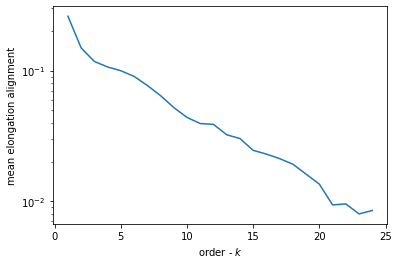

In [31]:
mean_alignment_k = [np.mean(cells_alignment_k) for cells_alignment_k in cells_alignment_k_list]

ax = plt.subplot(xlabel='order - $k$', ylabel = 'mean elongation alignment')
ax.plot(range(1,len(mean_alignment_k)+1), mean_alignment_k)
ax.set_yscale('log')
plt.savefig('cell_alignment.png',dpi=600)
plt.show()

### Save alignment data to table

Save cell elongation alignment for every cell up to order 3:

In [ ]:
max_save_order = 3

# Put cell alignment value in cells table and save to DB.
for k in range(max_save_order):
    cells['elongation_alignment_order_' + str(k+1)] = cells_alignment_k_list[k]
    
MMTool.table_io_per_frame(datapath_movie_frames, table_name = 'cells', frameIdx = frameIdx, network_type = 'cells', action = 'save', table = cells)
print('done')

### Create VTK files to plot cells colored by alignment value
To plot cells colored with their alignment value at orders $0, \ldots,k$, goto the movie root dir and type

```bash
    python /path/to/cureved_tm_dir/curvedtm2vtk -n cells -s 'elongation_alignment_order_0' 'elongation_alignment_order_1' ...
```

or execute from console. Make sure to set path of python interperter.

In [ ]:
#Save current working dir
curwd = os.getcwd()
curvedtm2vtk_path = os.path.join(curwd, 'curvedtm2vtk.py')

python_interp = ''

os.chdir(datapath_movie_name)
!$python_interp $curvedtm2vtk_path -g $frameIdx -n cells -s 'elongation_alignment_order_1' 'elongation_alignment_order_2' 'elongation_alignment_order_3'

#Return to this dir.
os.chdir(curwd)